## Data


Data is from a kaggle competition - https://www.kaggle.com/competitions/dog-breed-identification/data. Let's download and unzip it.

## Import Libraries

Transfer learning involves employing a pre-trained model and customizing it to address a specific problem. This approach is favored over training a model from scratch due to the time and resources required. By leveraging the learned patterns of an existing model, typically trained to classify images, we can adapt it to our own dataset.

In [23]:
# Import necessary libraries for the project
import tensorflow as tf  # TensorFlow for building and training the model
import tensorflow_hub as hub  # TensorFlow Hub for leveraging pre-trained models
import pandas as pd  # Pandas for data manipulation
import numpy as np  # NumPy for numerical operations
from sklearn.model_selection import train_test_split  # For splitting the data
from matplotlib.pyplot import imread  # For reading images
from IPython.display import display, Image  # For displaying images

# Check the versions of TensorFlow and TensorFlow Hub
print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)


TensorFlow version: 2.16.1
TensorFlow Hub version: 0.16.1


## Exploratory Data Analysis

In [7]:
import pandas as pd

# Adjust the path according to your directory structure
labels_csv = pd.read_csv("/Users/chandrajason/Library/CloudStorage/OneDrive-TheUniversityofChicago/GIT/Jason Chandra Repository/Dog_Classifier/RawData-Kaggle/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


- 10222 different ID's (meaning 10222 different images) and 120 different breeds.


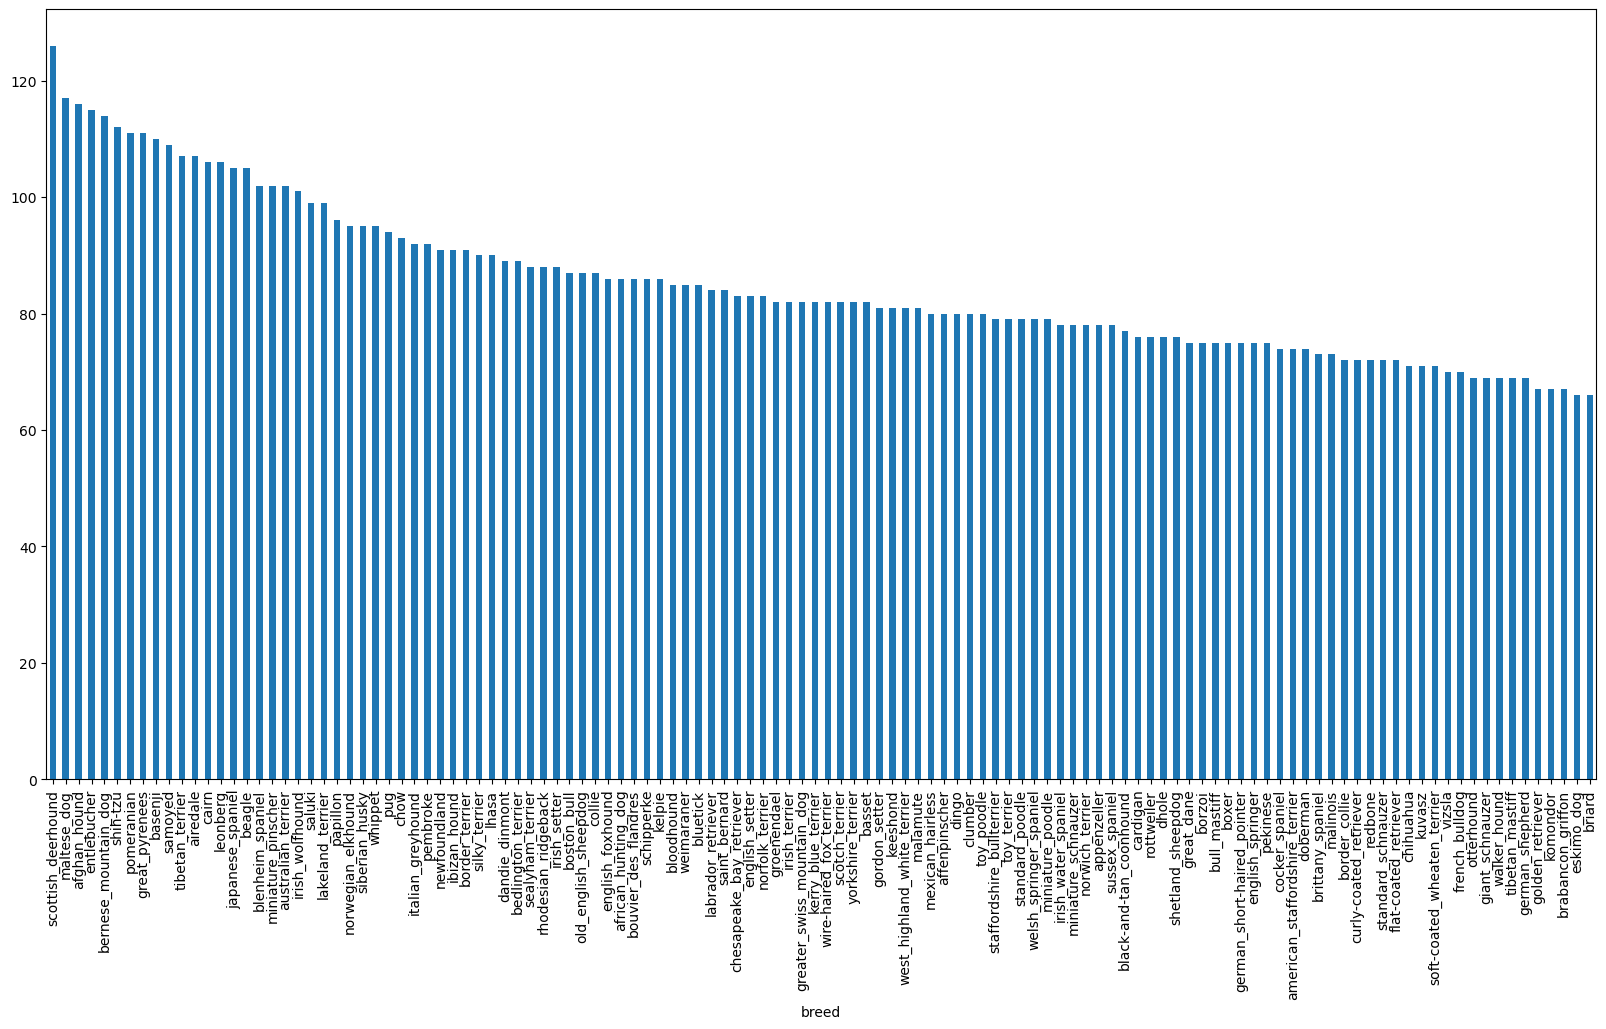

In [8]:
# How many images of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));
     

## Preparing the Data for the Model

- Constructs a list of file paths for the training images by concatenating the image IDs from the DataFrame with the directory path and file extension ".jpg".
- Prints the first 10 file paths to verify that they are correctly constructed.


In [9]:
# Create pathnames from image IDs
filenames = ["/Users/chandrajason/Library/CloudStorage/OneDrive-TheUniversityofChicago/GIT/Jason Chandra Repository/Dog_Classifier/RawData-Kaggle/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
print(filenames[:10])


['/Users/chandrajason/Library/CloudStorage/OneDrive-TheUniversityofChicago/GIT/Jason Chandra Repository/Dog_Classifier/RawData-Kaggle/train/000bec180eb18c7604dcecc8fe0dba07.jpg', '/Users/chandrajason/Library/CloudStorage/OneDrive-TheUniversityofChicago/GIT/Jason Chandra Repository/Dog_Classifier/RawData-Kaggle/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg', '/Users/chandrajason/Library/CloudStorage/OneDrive-TheUniversityofChicago/GIT/Jason Chandra Repository/Dog_Classifier/RawData-Kaggle/train/001cdf01b096e06d78e9e5112d419397.jpg', '/Users/chandrajason/Library/CloudStorage/OneDrive-TheUniversityofChicago/GIT/Jason Chandra Repository/Dog_Classifier/RawData-Kaggle/train/00214f311d5d2247d5dfe4fe24b2303d.jpg', '/Users/chandrajason/Library/CloudStorage/OneDrive-TheUniversityofChicago/GIT/Jason Chandra Repository/Dog_Classifier/RawData-Kaggle/train/0021f9ceb3235effd7fcde7f7538ed62.jpg', '/Users/chandrajason/Library/CloudStorage/OneDrive-TheUniversityofChicago/GIT/Jason Chandra Repository/Dog_Cl

- verify if the number of filenames matches the actual number of image files:

In [11]:
import os

# Check whether the number of filenames matches the number of actual image files
if len(os.listdir("/Users/chandrajason/Library/CloudStorage/OneDrive-TheUniversityofChicago/GIT/Jason Chandra Repository/Dog_Classifier/RawData-Kaggle/train/")) == len(filenames):
  print("Filenames match the actual number of files!")
else:
  print("Filenames do not match the actual number of files. Please check the target directory.")


Filenames match the actual number of files!


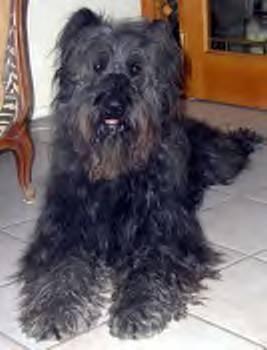

In [14]:
# Check an image directly from a filepath
from IPython.display import display, Image
Image(filenames[4592])

- convert the labels into a NumPy array:

In [15]:
import numpy as np

# Convert the labels column to a NumPy array
labels = labels_csv["breed"].to_numpy()

# Display the first 10 labels
print(labels[:10])


['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'bedlington_terrier' 'borzoi' 'basenji'
 'scottish_deerhound']


In [16]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


In [18]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [20]:
print(unique_breeds[:10])

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle']


In [21]:
# Convert each label to a boolean array: True where the label equals the unique breed, False otherwise
boolean_labels = [label == unique_breeds for label in labels]

### Creating a validation set via T-T-S

In [24]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(filenames, boolean_labels, test_size=0.2, random_state=42)
print(len(X_train), len(y_train), len(X_val), len(y_val))


8177 8177 2045 2045


### Image preprocessing - Transforming images into tensors

To prepare our dataset for a TensorFlow model, it's necessary to convert our image data into a format it understands: Tensors.

Tensors are the primary data structure used in TensorFlow, much like how NumPy arrays are used for scientific computing. They allow for efficient computation on GPUs, which significantly speeds up training times for deep learning models.

The process of converting our images—currently referenced by file paths—into Tensors involves a few key steps:

1. **Reading the Image File:** We start by taking an image file path and using TensorFlow to read the image data from disk.
2. **Decoding and Normalizing:** The raw image data is then decoded from JPEG format into a Tensor, and its pixel values are scaled to a range of 0 to 1. This normalization step helps our model train more effectively.
3. **Resizing the Image:** Since our neural network model expects inputs of a specific size, we resize the image to fit these dimensions, specifically \(224 \times 224\) pixels.
4. **Returning the Processed Image:** The final, resized image tensor is now ready to be used by our model.

The choice of \(224 \times 224\) pixels for image dimensions is model-specific; it's a common size for inputs to convolutional neural networks (CNNs) used in image tasks. The "3" in \(224 \times 224 \times 3\) refers to the three color channels (RGB) that make up each pixel, representing the red, green, and blue components.

This preparation process is crucial for ensuring that all images fed into our model are uniform in size and scale, enabling consistent training and prediction performance.


In [25]:
# Define the image size to match the model's expected input
IMG_SIZE = 224

def process_image(image_path):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    image = tf.io.read_file(image_path)  # Read in the image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the jpeg into a Tensor with 3 colour channels
    image = tf.image.convert_image_dtype(image, tf.float32)  # Scale the image data to [0, 1] range
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize the image to the specified size
    
    return image


### Data Batch Creation

Now that our images are processed into tensors, the next step is to batch these images to make them ready for model training. Batching involves grouping a set of images and labels together into a single bundle; this allows our model to train on a subset of data at a time, which is more memory-efficient.

In [26]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [27]:
import tensorflow as tf

# Function to create data batches
def create_data_batches(X, y=None, batch_size=32, valid_data=False, test_data=False):
    """
    Create batches of data from image file paths and labels.
    - X: List of image file paths
    - y: Corresponding labels (None if test_data=True)
    - batch_size: Size of each data batch
    - valid_data: Is the dataset validation dataset? (Boolean)
    - test_data: Is the dataset test dataset? (Boolean)
    """
    # If the dataset is a test or validation set, we don't have labels
    if test_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))  # Only filepaths
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch
    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # Filepaths
                                                   tf.constant(y)))  # Labels
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # Filepaths
                                                   tf.constant(y)))  # Labels
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

# Creating training and validation batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)


In [28]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

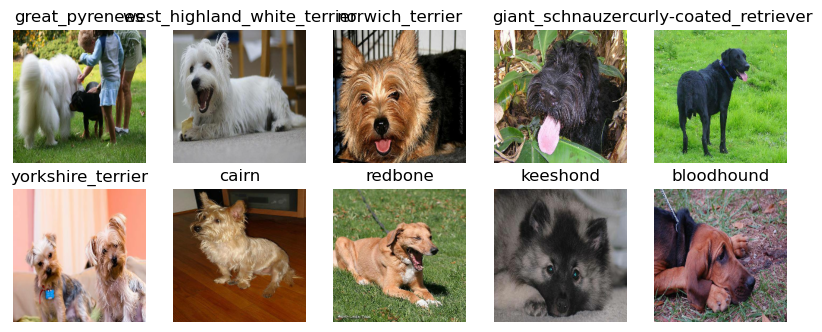

In [30]:
#### Visualizing some images in a batch.- 

import matplotlib.pyplot as plt

def show_10_images(images, labels):
    """
    Displays 10 images from a data batch.
    """
    plt.figure(figsize=(10, 10))
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")
        
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_10_images(train_images, train_labels)
